Antes de empezar debemos importar los paquetes y módulos que vamos a necesitar durante este análisis. En concreto, vamos a importar el paquete de visualización *matplotlib*, el módulo *Pandas* para trabajar con datos tabulares y algunas funciones de *Spark*.

***Nota: Al estar en windows no usare Spark ni Hadoop en esta oportunidad, lo hare creativamente con sqlite***

In [107]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sqlite3 as sq

En las celdas siguientes configuramos un enlace para acceder a los datos de Hive y definimos dos Spark Dataframes que harán referencia a los datos de las dos tablas externas de Hive (voto_csv y usuario_csv).

In [108]:
sdf_user = sq.connect('usuarios.db')
sdf_usuarios = pd.read_sql("SELECT * FROM usuarios",sdf_user)
sdf_votos = pd.read_sql("SELECT * FROM votos",sdf_user)

Una vez inicializados estos objetos en Spark, podemos mostrar su modelo de datos para comprobar que todo es correcto.

In [109]:
sdf_votos

,id_galaxia,id_usuario,forma,tiempo
0,587739829276311756,10404,1,6.614253
1,587744728760910031,10404,1,35.489287
2,587738195050823924,10404,0,2.594505
3,587735349639184468,10404,1,3.218166
4,588017726552015023,10404,1,7.687656
...,...,...,...,...
379144,587732482729771307,3071,0,3.647347
379145,587731891649904717,14865,0,1.638407
379146,587725819092467967,13786,1,2.872656
379147,587735043078357082,10871,0,5.091615


In [110]:
sdf_usuarios

,id_usuario,edad,pais
0,1,39,Bolívia
1,3,40,Nicaragua
2,4,36,España
3,5,26,Argentina
4,6,28,Costa Rica
...,...,...,...
14914,15232,46,Venezuela
14915,15233,38,Venezuela
14916,15234,64,México
14917,15235,45,España


# Estudio y limpieza de los datos de usuario

Para empezar, vamos a mostrar algunos registros de usuarios usando el método *show*

In [111]:
sdf_usuarios.head(5)

,id_usuario,edad,pais
0,1,39,Bolívia
1,3,40,Nicaragua
2,4,36,España
3,5,26,Argentina
4,6,28,Costa Rica


Y podemos contar cuantos usuarios han participado en total usando la método *count()*.

In [112]:
sdf_usuarios.count()

id_usuario    14919
edad          14919
pais          14919
dtype: int64

## País

Para empezar, vamos a generar un histograma con los paises de todos los usuarios que han participado usando las funcionalidades presentes en Spark. Para ello, ejecuta la celda siguiente:

In [113]:
hist_usuarios_pais = sdf_usuarios.groupby('pais')["pais"].count()
hist_usuarios_pais.head()

pais
Argentina     1403
Bolívia        358
Chile          530
Colombia      1636
Costa Rica     155
Name: pais, dtype: int64

La celda anterior agrupa los usuarios según su país y luego cuenta el número de usuarios que hay en cada grupo (país).
Podemos visualizar esta información con las funcionalidades de Matplotlib que están integradas en Pandas. Ejecuta la celda siguiente para mostrar el histograma como un gráfico de barras:

<Axes: xlabel='pais'>

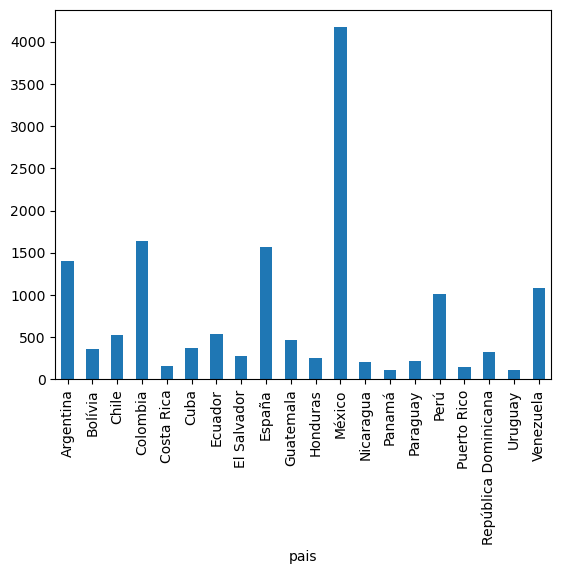

In [114]:
hist_usuarios_pais.plot(kind='bar')

En el gráfico anterior, en el eje X nos muestra la posición en lugar del nombre del país. Para cambiar esto, nos conviene definir el índice del Pandas DataFrame usando el método *set_index*. Ejecuta la siguente celda para ver el resultado:

In [115]:
# No es Necesario

#hist_usuarios_pais.set_index('pais').plot(kind='bar')

Ahora podemos ver claramente que el país que más participantes ha tenido (más de 4000) ha sido México, y el que menos, parece ser Uruguay. Como no queda muy claro, vamos a ordenar los valores de este histograma usando el método *sort_values*. Ejecuta la celda siguiente para ver el resultado:

<Axes: xlabel='pais'>

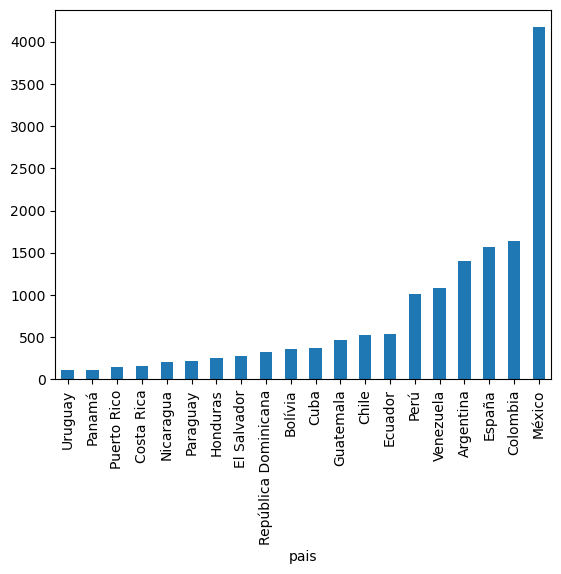

In [116]:
hist_usuarios_pais.sort_values().plot(kind='bar')

Ahora sí podemos ver claramente que Uruguay es el país que menos participantes ha tenido, aunque seguido bien de cerca por Panamá o Puerto Rico, entre otros.

## Edad

En segundo lugar, vamos a estudiar la distribución de edades de los participantes. Para ello, vamos a construir un histogramamuy similar al anterior pero, en este caso, en lugar de agrupar por país, vamos a agrupar por edad. Completa la linea siguiente para generar los datos del histograma:

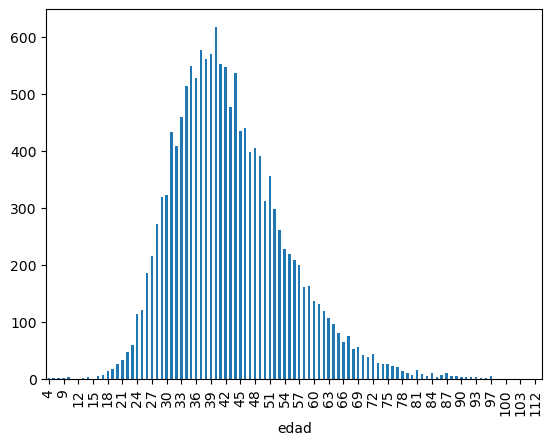

In [117]:

# Obtener el histograma de votos por edad
hist_votos_edad = sdf_usuarios.groupby('edad')["edad"].count()

# Crear el gráfico de barras
ax = hist_votos_edad.plot(kind='bar')

# Definir los ticks del eje x
xticks = range(0, len(hist_votos_edad), 3)
ax.set_xticks(xticks)

# Mostrar el gráfico
plt.show()

Para mostrar los datos de este histograma usaremos otro tipo de gráfico, llamado "scatter". Si todo ha ido bien en la celda anterior, ejecuta la celda siguiente para visualizar el gráfico:

<Axes: xlabel='edad', ylabel='pais'>

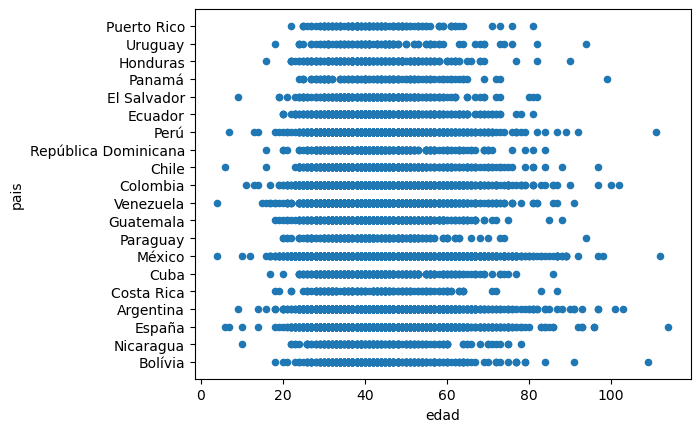

In [118]:
#hist_usuarios_edad.plot('edad', 'count', kind='scatter')
sdf_usuarios.plot("edad","pais",kind="scatter")

En este gráfico podemos ver como hay participantes menores de 10 años y mayores de 100. Más adelante nos va a interesar filtrar los votos de estos usuarios, pues pueden ser poco fiables. Vamos a ver cuantos usuarios hay que tengan menos de 10 años, para ello, ejecuta la celda siguiente:

In [119]:
sdf_usuarios.query('edad < 10')["edad"].count()

8

Deberías haber obtenido un resultado de 8 usuarios menores de 10 años. Para saber cuántos usuarios mayores de 100 años han participado, completa la celda siguiente y ejecútala:

In [120]:
sdf_usuarios.query('edad > 100')["edad"].count()

7

Deberías haber obtenido 7 como resultado.

Finalmente, vamos a generar el conjunto de datos limpio filtrando sólo los usuarios que tengan edades comprendidas entre los 10 y los 100 años, ambos incluidos. En la celda siguiente, generamos este conjunto de datos limpio y contamos cuantos usuarios nos han quedado.

In [121]:
sdf_usuarios_limpio = sdf_usuarios.query('edad >= 10 and edad <= 100')
sdf_usuarios_limpio.count()

id_usuario    14904
edad          14904
pais          14904
dtype: int64

Deberían quedarnos $14919 - 8 - 7 = 14904$

In [122]:
sdf_usuarios_limpio

,id_usuario,edad,pais
0,1,39,Bolívia
1,3,40,Nicaragua
2,4,36,España
3,5,26,Argentina
4,6,28,Costa Rica
...,...,...,...
14914,15232,46,Venezuela
14915,15233,38,Venezuela
14916,15234,64,México
14917,15235,45,España


# Estudio y limpieza de los datos de votos

Una vez analizados los datos de los usuarios, vamos a hacer lo mismo con los votos. Ejecuta la celda siguiente para ver información de algunos votos:

In [123]:
sdf_votos.head(5)

,id_galaxia,id_usuario,forma,tiempo
0,587739829276311756,10404,1,6.614253
1,587744728760910031,10404,1,35.489287
2,587738195050823924,10404,0,2.594505
3,587735349639184468,10404,1,3.218166
4,588017726552015023,10404,1,7.687656


Y podemos contar cuantos votos hemos recodigo en total usando la método *count()*.

In [124]:
sdf_votos.count()

id_galaxia    379149
id_usuario    379149
forma         379149
tiempo        379149
dtype: int64

## Tiempo de respuesta

Ahora vamos a estudiar la distribución del tiempo de respuesta, para ver cómo de rápido han sido los participantes a la hora de clasificar las galaxias según su forma.

Como puedes observar en el resultado mostrado en la celda anterior, en este caso tenemos una complejidad adicional que es el hecho de que el tiempo de respuesta no es un valor con el cual podamos agrupar directamente, ya que no es un valor categórico y cada voto tiene un tiempo de respuesta distinto.

Para poder agrupar los distintos votos, deberemos crear categorías artificiales, por ejemplo agrupando los tiempos de respuesta en bloques de un segundo. Para llevar a cabo esta agrupación podemos usar la función *floor* en la que, dado un tiempo de respuesta, nos va a devolver la parte entera despreciando la parte decimal. De esta manera, varios votos que hayan tardado 3.425, 3.019 o 3.978 segundos van a quedar agrupados en la misma categoria, los que han tardado de 3 a 4 segundos.

Vamos a generar esta columna extra con el método *withColumn* aplicando esta función *floor*. Ejecuta la celda siguiente para ver esta nueva columna:

In [125]:
sdf_votos["segundos"] = sdf_votos["tiempo"].astype(int)
sdf_votos["segundos"]

0          6
1         35
2          2
3          3
4          7
          ..
379144     3
379145     1
379146     2
379147     5
379148     0
Name: segundos, Length: 379149, dtype: int32

Fíjate como a varios valores de la columna tiempo se les asigna el mismo número de segundos. Ahora ya sí podemos agrupar por esta columna nueva y generar el histograma.

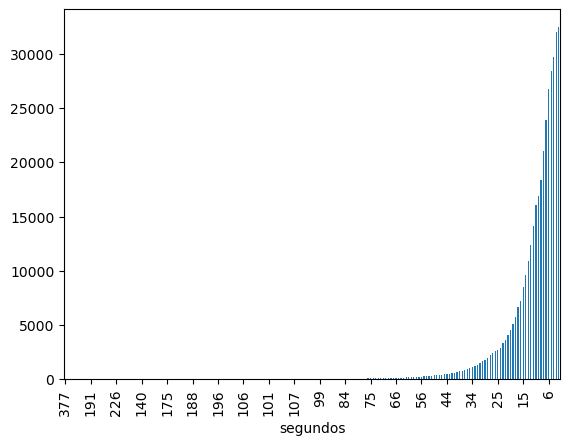

In [126]:
# Obtener el histograma de votos por segundos
hist_votos_tiempo = sdf_votos.groupby('segundos')['segundos'].count()

# Ordenar los valores
hist_votos_tiempo = hist_votos_tiempo.sort_values()

# Crear el gráfico de barras
ax = hist_votos_tiempo.plot(kind='bar')

# Definir los ticks del eje x
xticks = range(0, len(hist_votos_tiempo), 10)
ax.set_xticks(xticks)

# Mostrar el gráfico
plt.show()


Visualiza ahora tu mismo este mismo histograma usando un gráfico de tipo "scatter". Sólo tienes que completar la celda inferior y ejecutarla.

In [127]:
#No es necesario
#sdf_votos.plot('segundos', 'pais', kind = 'scatter')

Lo primero que podemos ver en este gráfico es que parece ser que hay clasificaciones donde el usuario se ha tomado su tiempo para decidirse. Hay bastantes votos en los que el usuario ha necesitado más de 60 segundos para decidirse, incluso algunos han tardado más de 300 segundos (5 minutos). Es muy probable que no nos interese tener en cuenta estos votos, ya que la información que contienen podría ser problemática.

Calcula el número de votos que han tomado 60 segundos o más en generarse completando y ejecutando la celda siguiente:

In [128]:
sdf_votos.query('tiempo >= 60')["tiempo"].count()

2866

Debería obtener el valor 2866.

Por otro lado, en la visualización anterior perdemos el detalle de lo que sucede para tiempos reducidos. Hay un parámetro *xlim* que se le puede pasar al método *plot* para especificar el rango que queremos que nos muestre en el eje X. Añade este parámetro con el valor [-1, 30] en la siguiente celda y vuelve a generar el gráfico.

In [129]:
#hist_votos_tiempo.plot(['segundos', 'count'], kind = 'scatter', xlim=[-1,30])

Si lo has hecho correctamente podrás observar como hay algunas clasificaciones que se han realizado en menos de un segundo, ya que aparecen agrupadas en la coordenada 0. Calcula el número de votos que se han realizado en menos de un segundo completando y ejecutando la celda siguiente:

In [130]:
sdf_votos.query('tiempo < 1')["tiempo"].count()

2639

Deberías obtener el valor 2639.

Estos votos también podría interesarnos no tenerlos en cuenta, ya que es bastante probable que el usuario no le haya prestado suficiente atención.

Para ir finalizando, vamos a generar un conjunto de datos limpio que sólo contenga los votos en los que el tiempo de respuesta sea mayor de un segundo y menor de sesenta. Completa la celda inferior para generar este conjunto de datos limpio y mostrar algunos registros.

In [131]:
sdf_votos_limpio = sdf_votos.query('tiempo > 1 and tiempo < 60')
sdf_votos_limpio.head(5)

,id_galaxia,id_usuario,forma,tiempo,segundos
0,587739829276311756,10404,1,6.614253,6
1,587744728760910031,10404,1,35.489287,35
2,587738195050823924,10404,0,2.594505,2
3,587735349639184468,10404,1,3.218166,3
4,588017726552015023,10404,1,7.687656,7


Y, por último, usa el método *count* en este conjunto de datos limpio para calcular cuantos votos nos han quedado después de sanear los datos.

In [132]:
sdf_votos_limpio.count()["segundos"]

373644

# Combinación de los datos limpios

Ahora que tenemos los dos conjuntos de datos limpios, vamos a combinarlos para estudiarlos en su conjunto. Para ello usaremos el método *join* para combinar ambos por la columna que tienen en común, que es el identificador del usuario.

In [133]:
sdf_combinado = pd.merge(sdf_votos_limpio, sdf_usuarios_limpio, on='id_usuario', how='outer')
sdf_combinado.head()

,id_galaxia,id_usuario,forma,tiempo,segundos,edad,pais
0,5.877398e+17,10404,1.0,6.614253,6.0,41.0,Argentina
1,5.877447e+17,10404,1.0,35.489287,35.0,41.0,Argentina
2,5.877382e+17,10404,0.0,2.594505,2.0,41.0,Argentina
3,5.877353e+17,10404,1.0,3.218166,3.0,41.0,Argentina
4,5.880177e+17,10404,1.0,7.687656,7.0,41.0,Argentina


Al combinar estos dos conjuntos de datos vamos a generar un conjunto de datos aún más limpio, ya que en la combinación se van a descartar todos los votos de aquellos usuarios que hemos filtrado por estar fuera del rango de edad.

Calcula el número de registros del conjunto de datos combinados con el método *count*.

In [134]:
sdf_combinado.count()["edad"]

373455

Deberías obtener el resultado 373451, lo que nos indica que en la combinación de los dos conjuntos de datos, se han descartado $373644 - 373451 = 193$ votos adicionales.

## Votos según el país

Ahora que tenemos los datos combinados, podemos sacar información adicional sobre estos datos. Por ejemplo, podemos calcular el histograma de número de votos por país. En la celda siguiente tienes el código para generar los datos para el histograma del número de votos por país.

In [135]:
hist_votos_pais = sdf_combinado.groupby('pais')['pais'].count()
hist_votos_pais

pais
Argentina                35385
Bolívia                   9043
Chile                    13217
Colombia                 40772
Costa Rica                3866
Cuba                      9236
Ecuador                  13360
El Salvador               6851
España                   39368
Guatemala                11576
Honduras                  6212
México                  103783
Nicaragua                 5242
Panamá                    3011
Paraguay                  5511
Perú                     25504
Puerto Rico               3514
República Dominicana      8191
Uruguay                   2752
Venezuela                27061
Name: pais, dtype: int64

<Axes: xlabel='pais'>

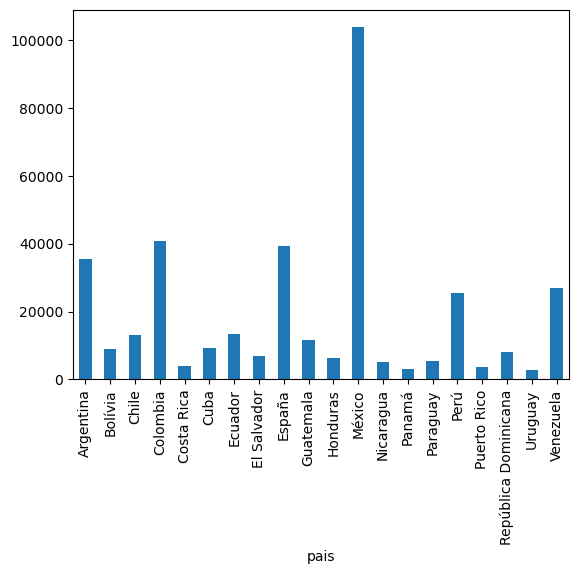

In [136]:
hist_votos_pais.plot(kind='bar')

Al igual que nos pasó al mostrar los datos del número de usuarios por país, en este gráfico nos aparece la posición del país en lugar de su nombre. Completa la celda inferior usando los métodos *set_index* y *sort_values* para generar una visualización donde aparezca el nombre el país en el eje X y los valores del histograma estén ordenados.

<Axes: xlabel='pais'>

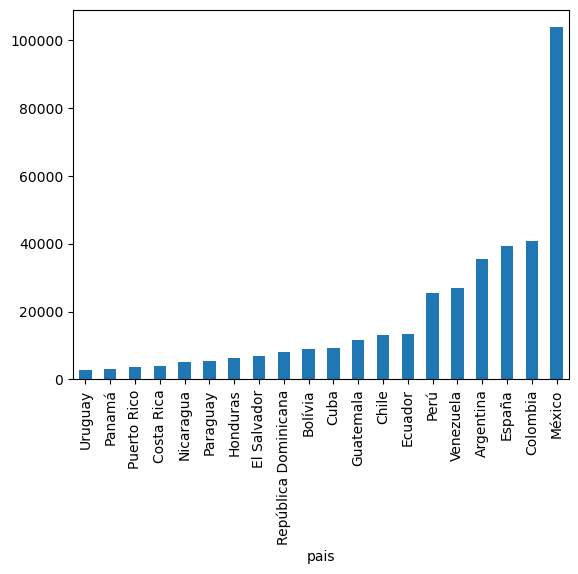

In [137]:
hist_votos_pais.sort_values().plot(kind='bar')

Como era de esperar México sigue liderando en el recuento de votos al tener también el mayor número de usuarios participantes.

El problema con esta visualización es que no podemos determinar si los usuarios de México o los de cualquier otro país han sido más productivos que el resto. Es decir, si los usuarios de algún país han sido generado, de media, más votos de los de otros países. Para saber esto, podemos calcular el número medio de votos por usuario de cada país, dividiendo los datos de los dos histogramas (el de número de votos por país y el de número de usuarios por país).

In [138]:
hist_media_voto_pais = hist_votos_pais / hist_usuarios_pais
hist_media_voto_pais

pais
Argentina               25.220955
Bolívia                 25.259777
Chile                   24.937736
Colombia                24.921760
Costa Rica              24.941935
Cuba                    25.097826
Ecuador                 25.018727
El Salvador             25.187500
España                  25.027336
Guatemala               25.110629
Honduras                25.149798
México                  24.888010
Nicaragua               25.323671
Panamá                  26.182609
Paraguay                25.050000
Perú                    25.351889
Puerto Rico             24.921986
República Dominicana    24.972561
Uruguay                 24.792793
Venezuela               24.964022
Name: pais, dtype: float64

Vamos a visualizar esta información ahora con un gráfico de barras.

<Axes: xlabel='pais'>

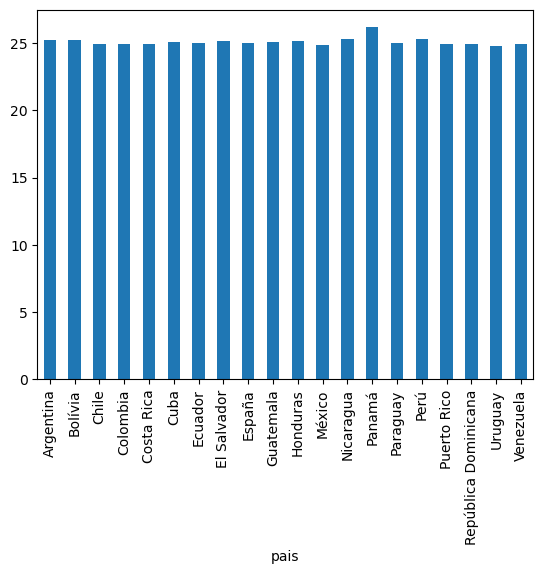

In [139]:
hist_media_voto_pais.plot(kind='bar')

A la vista de la información presentada, no parece haber diferencias significativas en la participación de los usuarios de cada país. De media, cada participante ha clasificado la forma de unas 25 galaxias.

## Votos según la edad

Sucederá lo mismo si estudiamos el número de votos medio segun la franja de edad? Completa las celdas siguientes para averiguarlo.

In [140]:
hist_votos_edad = sdf_combinado.groupby('edad').size() #["edad"].count()
hist_votos_edad

edad
10.0       4
11.0       1
12.0       1
13.0       2
14.0      21
        ... 
96.0      63
97.0     159
98.0      38
99.0      30
100.0     23
Length: 90, dtype: int64

In [141]:
#hist_votos_edad.plot('edad', 'count', kind='scatter')

A primera vista vemos una distribución del número de votos según la edad muy similar a la distribución de usuarios según la edad. Esto era esperable ya que las franjas con más usuarios también serán las que deberían haber generado más clasificaciones. Para poder salir de dudas, es necesario hacer como en el caso anterior y dividir la información de los dos histogramas para calcular el número medio de votos segun la edad.

In [142]:
hist_media_voto_edad = hist_votos_edad / hist_votos_edad
hist_media_voto_edad.head(10)

edad
10.0    1.0
11.0    1.0
12.0    1.0
13.0    1.0
14.0    1.0
15.0    1.0
16.0    1.0
17.0    1.0
18.0    1.0
19.0    1.0
dtype: float64

Si ves algun valor 'NaN' en la tabla anterior, no te preocupes, corresponden a datos de usuarios o votos que han sido filtrados (por edad o tiempo).

In [143]:
#hist_media_voto_edad.reset_index().plot('edad', 'count', kind='scatter')

Fíjate bien la gráfica anterior, pues presenta un comportamiento particular que deberás saber explicar más adelante.


# Generar la clasificación promedio

Una vez hemos limpiado y estudiado los datos y estamos conformes con su validez, es el momento de generar la clasificación ideal de cada una de las galaxias. Para ello, vamos a promediar el voto de todos los usuarios sobre cada una de las galaxias. Al habernos preocupado previamente de guardar la forma como un número (0 en caso de votar elíptica, y 1 en caso de votar espiral), esta operación va a ser muy sencilla. Si la mayoría de los usuarios han votado una imagen de una galaxia como elíptica, la media de sus votos debería ser cercana a 0. En caso contrario, si la mayoría de los votos han marcado una galaxia como espiral, la media de la columna forma debería ser cercana a 1.

Antes de continuar, recordemos el aspecto del conjunto de datos combinado con el método show.

In [144]:
sdf_combinado.head(5)

,id_galaxia,id_usuario,forma,tiempo,segundos,edad,pais
0,5.877398e+17,10404,1.0,6.614253,6.0,41.0,Argentina
1,5.877447e+17,10404,1.0,35.489287,35.0,41.0,Argentina
2,5.877382e+17,10404,0.0,2.594505,2.0,41.0,Argentina
3,5.877353e+17,10404,1.0,3.218166,3.0,41.0,Argentina
4,5.880177e+17,10404,1.0,7.687656,7.0,41.0,Argentina


Para generar la clasificación promedio, debemos agrupar por la columna que identifica únicamente a cada galaxia y calcular la media del campo forma. Completa la celda siguiente y ejecútala:

In [145]:
sdf_clasificado = sdf_combinado.groupby('id_galaxia')["forma"]
sdf_clasificado.head()

0         1.0
1         1.0
2         0.0
3         1.0
4         1.0
         ... 
188394    1.0
190975    0.0
191972    0.0
207240    1.0
214063    0.0
Name: forma, Length: 49290, dtype: float64

En la celda anterior podemos ver como para cada galaxia hemos obtenido su forma esperada segun la media de los votos. El último paso que nos queda es guardar esta información en otra tabla, que va a ser usada en la semana siguiente para entrenar un clasificador automatizado.

In [156]:
#sdf_clasificado.write.saveAsTable('target', mode='overwrite')